In [25]:
using PyPlot, StatsBase, Printf, DelimitedFiles;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

### Potential energy function its gradients

In [26]:
V(x; k=1.0) = sum(- (1.0 / 2.0) .* k .* x.^2 .+ (1.0 ./ 4.0) .* k .* x.^4)
V([0.0])

0.0

In [27]:
grad(x; k= 1.0) =  - k .* x .+ k .* x.^3

grad (generic function with 1 method)

### Replica MD with exchange

In [28]:
function exchange_temperature!(m2i, i2m, icount, x_replica, pot_fun::Function, temperature_replica)
    nreplica = length(x_replica)

    m_array = 1:nreplica
    t_array = temperature_replica[m_array]
    b_array = 1.0 ./ t_array
    i_array = m2i[m_array]
    v_array = map(pot_fun, x_replica[i_array])
    
    if mod(icount, 2) == 0
        m_lower = 1:2:(nreplica-1)
        m_higher = 2:2:nreplica
    else
        m_lower = 2:2:(nreplica-1)
        m_higher = 3:2:nreplica
    end
    
    iaccepted = 0
    for ipair = 1:length(m_higher)
        m1 = m_lower[ipair]
        m2 = m_higher[ipair]
        delta = (b_array[m2] - b_array[m1]) * (v_array[m1] - v_array[m2])
        if exp(-delta) > rand()
            m2i[m_array[m1]], m2i[m_array[m2]] = m2i[m_array[m2]], m2i[m_array[m1]]
            i2m[i_array[m1]], i2m[i_array[m2]] = i2m[i_array[m2]], i2m[i_array[m1]]
            iaccepted += 1
        end
    end

    return iaccepted / length(m_higher)
end

exchange_temperature! (generic function with 1 method)

In [29]:
nreplica = 4
temperature_replica = [0.01, 0.10, 0.30, 0.40];
nstep = 100;
nexchange = 10;
nset=10;
m2i = collect(1:nreplica)
i2m = collect(1:nreplica)


for j=1:nset

x_replica = []
for i = 1:nreplica
    x = [0.0]
    push!(x_replica, x)
end

io_replica = []
for i = 1:nreplica
    filename = "./REMDdata/replica$(i)_$(j)set.dat"
    io = open(filename, "w")
    push!(io_replica, io)
end

icount = 0
acceptance_ratio = 0.0
for iexchange = 1:nexchange
    for i = 1:nreplica
        x_replica[i] = propagate_md(grad, x_replica[i], temperature_replica[i2m[i]], nstep=nstep, io=io_replica[i]);
    end
    # do exchange
    acceptance_ratio += exchange_temperature!(m2i, i2m, icount, x_replica, y -> V(y, k=1.0), temperature_replica)
    icount += 1
end

for i = 1:nreplica
    close(io_replica[i])
end

end
#acceptance_ratio = acceptance_ratio / nexchange

### Trajectory analysis

In [85]:
traj_replica = []
temp_replica = []

for i = 1:nreplica
    filename = "./REMDdata/replica$(i)_1set.dat"
    data = readdlm(filename);
    push!(temp_replica, data[:, 1])
    push!(traj_replica, data[:, 2])
end
temp_replica

4-element Array{Any,1}:
 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01  …  0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]          
 [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]          
 [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4  …  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

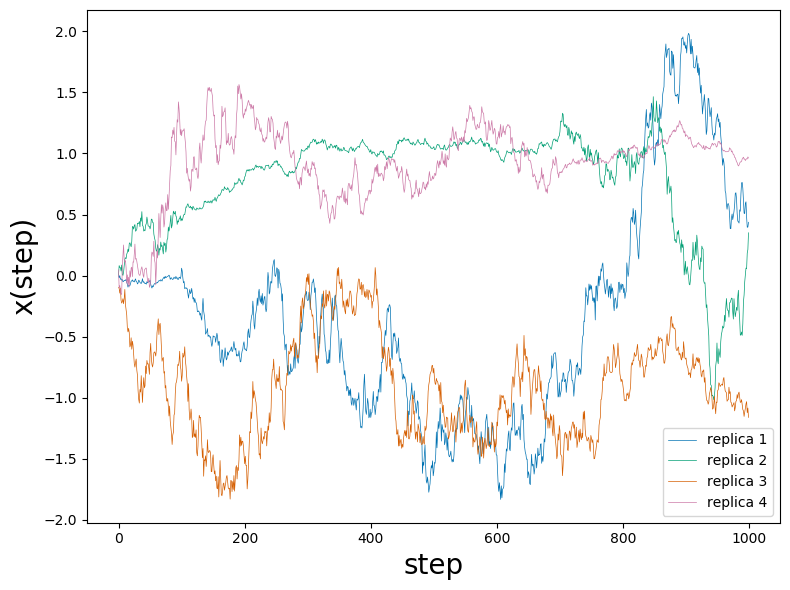

In [53]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_replica[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

In [54]:
# sort trajectories according to temperature
function sort_traj(traj_replica, temp_replica)
    traj_sorted = deepcopy(traj_replica)
    temp_sorted = deepcopy(temp_replica)
    nframe = size(traj_replica[1], 1)
    for iframe = 1:nframe
        temp_snapshot = map(x -> x[iframe], temp_replica)
        p = sortperm(temp_snapshot)
        for m = 1:nreplica
            traj_sorted[m][iframe, :] .= traj_replica[p[m]][iframe, :]
            temp_sorted[m][iframe, :] .= temp_replica[p[m]][iframe, :]
        end
    end
    return traj_sorted, temp_sorted
end

sort_traj (generic function with 1 method)

In [33]:
traj_sorted, temp_sorted = sort_traj(traj_replica, temp_replica)

(Any[[5.0e-6, -0.017573, 0.00011, -0.030593, -0.026228, -0.037938, -0.032196, -0.050731, -0.047788, -0.038527  …  0.962526, 0.969163, 0.953005, 0.955395, 0.941772, 0.950821, 0.957548, 0.955085, 0.971356, 0.962408], [0.00702, 0.081927, 0.066129, 0.06583, 0.03718, 0.08671, 0.008614, 0.001083, 0.027034, 0.08214  …  -1.096649, -1.108157, -1.153267, -1.116656, -1.087161, -1.05051, -1.031613, -1.122915, -1.084046, -1.161104], [-0.098117, -0.105153, -0.143733, -0.101673, -0.202448, -0.225205, -0.213863, -0.188994, -0.230647, -0.190777  …  0.713941, 0.611059, 0.510598, 0.507281, 0.59085, 0.604365, 0.479183, 0.395266, 0.397137, 0.436282], [0.046339, -0.098782, -0.081473, -0.132341, -0.15612, -0.15057, 0.080634, 0.170568, 0.250526, 0.127401  …  -0.392524, -0.212244, -0.159843, -0.051475, 0.003386, 0.061381, 0.05616, 0.184393, 0.213055, 0.350413]], Any[[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01  …  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], [0.1, 0.1, 0.1, 0.1, 

In [34]:
temp_sorted[1]

1000-element Array{Float64,1}:
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 ⋮   
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01

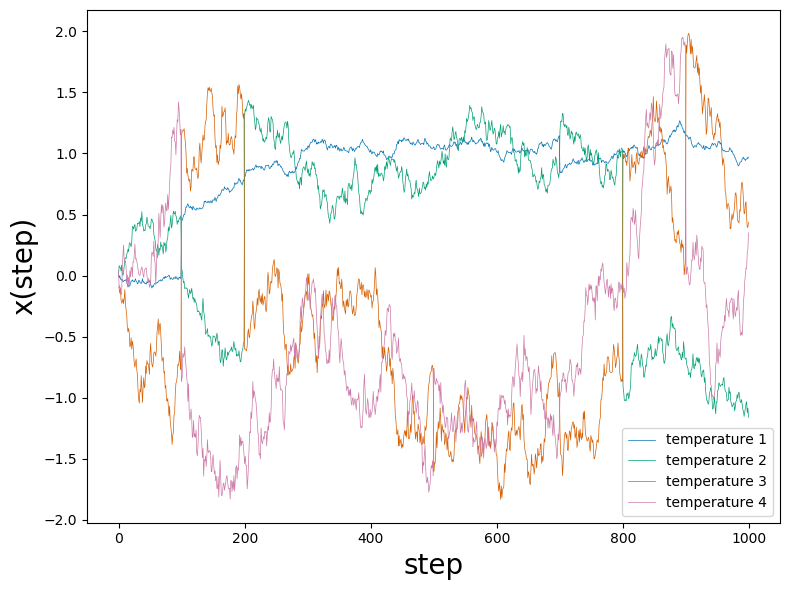

In [35]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_sorted[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["temperature 1", "temperature 2", "temperature 3", "temperature 4"])
tight_layout()

In [37]:
x_grid = range(-1.3, 1.3, length=100);
pmf_theory = V.(x_grid, k=1) ./ temperature_replica[1]
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [38]:
pmf_observed, _ = getpmf(traj_sorted[1], grid_x = collect(x_grid), bandwidth=0.05);

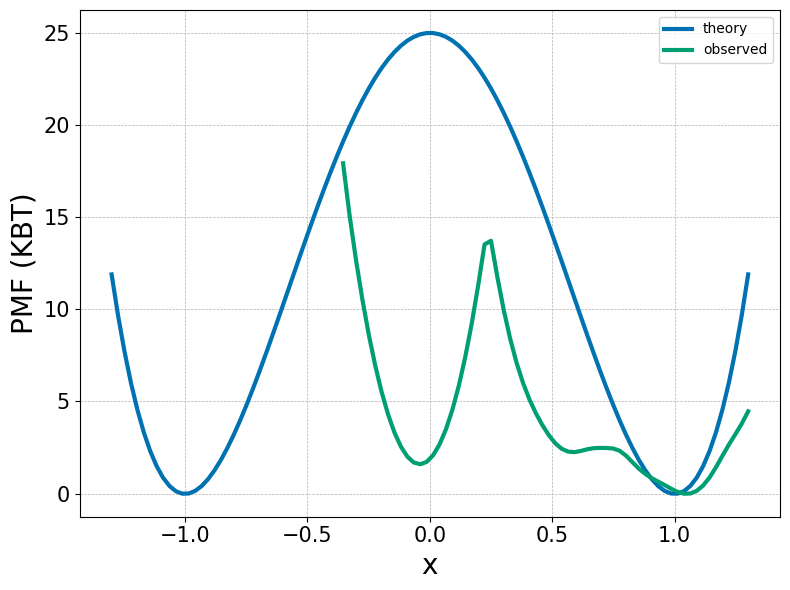

In [40]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("test_md_replica_exchange.png", dpi=350)



欲しいものは温度IDmの座標xにおけるpmfの標準偏差
標準偏差　sigma[x] <- pmf_observed

pmf_observed <- 　traj_sorted
traj_sorted <- traj_replica




In [68]:
using Statistics

#std()<-数値配列を渡すとそれらの標準偏差が返ってくる


In [93]:
traj_set = []
temp_set = []

#traj_set = zeros(zeros(Float64,nreplica),nset)
#temp_set = zeros(Float64,nset)
for j = 1:nset
traj_tmp = []
temp_tmp = []

for i = 1:nreplica
    filename = "./REMDdata/replica$(i)_1set.dat"
    data = readdlm(filename);
    push!(temp_tmp, data[:, 1])
    push!(traj_tmp, data[:, 2])
end
push!(temp_set,temp_tmp)
push!(traj_set,traj_tmp)

end
#traj_set[set][repID][step]


In [92]:
# sort trajectories according to temperature
function sort_traj(traj_replica, temp_replica)
    traj_sorted = deepcopy(traj_replica)
    temp_sorted = deepcopy(temp_replica)
    nframe = size(traj_replica[1], 1)
    for iframe = 1:nframe
        temp_snapshot = map(x -> x[iframe], temp_replica)
        p = sortperm(temp_snapshot)
        for m = 1:nreplica
            traj_sorted[m][iframe, :] .= traj_replica[p[m]][iframe, :]
            temp_sorted[m][iframe, :] .= temp_replica[p[m]][iframe, :]
        end
    end
    return traj_sorted, temp_sorted
end

sort_traj (generic function with 1 method)

In [100]:
traj_set_sorted = deepcopy(traj_set)
temp_set_sorted = deepcopy(temp_set)
for j = 1:nset 
traj_set_sorted[j],temp_set_sorted[j] = sort_traj(traj_set[j], temp_set[j])
end
traj_set_sorted[1]

4-element Array{Any,1}:
 [5.0e-6, -0.017573, 0.00011, -0.030593, -0.026228, -0.037938, -0.032196, -0.050731, -0.047788, -0.038527  …  0.962526, 0.969163, 0.953005, 0.955395, 0.941772, 0.950821, 0.957548, 0.955085, 0.971356, 0.962408]    
 [0.00702, 0.081927, 0.066129, 0.06583, 0.03718, 0.08671, 0.008614, 0.001083, 0.027034, 0.08214  …  -1.096649, -1.108157, -1.153267, -1.116656, -1.087161, -1.05051, -1.031613, -1.122915, -1.084046, -1.161104]     
 [-0.098117, -0.105153, -0.143733, -0.101673, -0.202448, -0.225205, -0.213863, -0.188994, -0.230647, -0.190777  …  0.713941, 0.611059, 0.510598, 0.507281, 0.59085, 0.604365, 0.479183, 0.395266, 0.397137, 0.436282]
 [0.046339, -0.098782, -0.081473, -0.132341, -0.15612, -0.15057, 0.080634, 0.170568, 0.250526, 0.127401  …  -0.392524, -0.212244, -0.159843, -0.051475, 0.003386, 0.061381, 0.05616, 0.184393, 0.213055, 0.350413]   

In [102]:
x_grid = range(-1.3, 1.3, length=100);
pmf_theory = V.(x_grid, k=1) ./ temperature_replica[1]
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [103]:
pmf_observed, _ = getpmf(traj_set_sorted[1][1], grid_x = collect(x_grid), bandwidth=0.05);

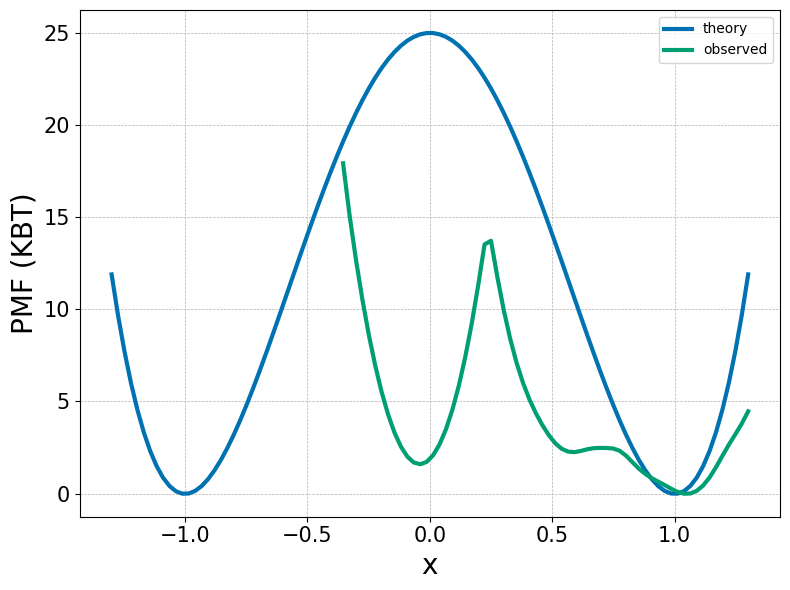

In [104]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("test_md_replica_exchange.png", dpi=350)

In [108]:
asd, _ = 100

BoundsError: BoundsError: attempt to access 100
  at index [2]